# 图像标题与RNNs
在这个练习中，您将实现一个普通的递归神经网络，并使用它们来训练一个可以为图像生成新标题的模型。

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## 安装h5py
我们将使用的COCO数据集以HDF5格式存储。要加载HDF5文件，我们需要安装' h5py ' Python包。从命令行运行:<br/>
`pip install h5py`   <br/>
如果您收到权限错误，您可能需要以根用户身份运行该命令:<br/>
```sudo pip install h5py```
你也可以直接从Jupyter笔记本上运行命令，方法是在命令前面加上“!”字符:

# 微软COCO
对于这个练习，我们将使用2014年发布的[Microsoft COCO数据集](http://mscoco.org/)，它已经成为图像字幕的标准测试平台。该数据集包括80,000张培训图像和40,000张验证图像，每个图像都有5个由Amazon Mechanical Turk上的工作人员编写的注释。
通过切换到“cs231n/datasets”目录并运行脚本“get_assignment3_data.sh”，您应该已经下载了数据。如果您还没有这样做，现在就运行这个脚本。警告:可可数据下载是~1GB。
我们已经对数据进行了预处理并为您提取了特征。对于所有的图像，我们提取了在ImageNet上预先训练的VGG-16网络的fc7层的特征;这些特性存储在文件的train2014_vgg16_fc7.h5’和‘val2014_vgg16_fc7.h5。为了减少处理时间和内存需求，我们将特征的维数从4096降至512;这些特性可以在train2014_vgg16_fc7_pca.h5’和‘val2014_vgg16_fc7_pca.h5”中找到。
原始图像占用了大量空间(近20GB)，所以我们没有在下载中包含它们。但是，所有图像都是从Flickr获取的，培训和验证图像的url存储在文件的train2014_urls.txt”和“val2014_urls.txt。这允许您动态下载图像以实现可视化。由于图像是动态下载的，**您必须连接到互联网才能查看图像**。
处理字符串的效率很低，所以我们将使用字幕的编码版本。每个单词都分配了一个整数ID，允许我们用一个整数序列来表示标题。整数id和单词之间的映射在文件“coco2014_vocab”中。可以使用文件cs231n/coco_utils中的函数decode_captions。将整数id的numpy数组转换回字符串。
我们向词汇表中添加了一些特殊的标记。我们在每个标题的开头和结尾分别添加一个特殊的' <START> '令牌和' <END> '令牌。罕见的单词被替换为特殊的“<UNK>”令牌(表示“未知”)。此外，由于我们希望使用包含不同长度标题的小批量进行训练，所以我们在' <END> '标记之后用特殊的' <NULL> '标记填充短标题，并且不计算' <NULL> '标记的丢失或梯度。由于它们有点麻烦，我们已经为您处理了关于特殊令牌的所有实现细节。
可以使用“cs231n/coco_utils.py”文件中的“load_coco_data”函数加载所有MS-COCO数据(标题、特性、url和词汇表)。运行以下单元格:

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## 看看数据
在使用数据集之前，从数据集查看示例总是一个好主意。
您可以使用文件“cs231n/coco_utils”中的“sample_coco_minibatch”函数。从load_coco_data返回的数据结构中提取少量数据。运行以下命令对一小批训练数据进行采样，并显示图像及其说明。多次运行它并查看结果可以帮助您了解数据集。
请注意，我们使用' decode_captions '函数来解码字幕，我们使用Flickr URL动态下载图像，因此**您必须连接到互联网才能查看图像**。

In [3]:
# # Sample a minibatch and show the images and captions
# batch_size = 3

# captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
# for i, (caption, url) in enumerate(zip(captions, urls)):
#     plt.imshow(image_from_url(url))
#     plt.axis('off')
#     caption_str = decode_captions(caption, data['idx_to_word'])
#     plt.title(caption_str)
#     plt.show()

# 递归神经网络
正如在课堂上所讨论的，我们将使用递归神经网络(RNN)语言模型进行图像字幕。文件的cs231n/rnn_layers.py '包含递归神经网络所需的不同层类型的实现，以及文件'cs231n/classifier/rnn.py'使用这些层来实现一个图像字幕模型。
我们将首先在“cs231n/rnn_layers.py”中实现不同类型的RNN层。

# Vanilla RNN:单步前向
打开文件“cs231n/rnn_layers.py”。该文件实现了递归神经网络中常用的不同类型的层的向前和向后传递。
首先实现函数“rnn_step_forward”，该函数实现普通递归神经网络单个时间步长的前向遍历。这样做之后，运行以下代码来检查您的实现。您应该看到错误小于1e-8。

In [4]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN:单步后向
在文件' cs231n/rnn_layers中。实现' rnn_step_back '函数。这样做之后，运行下面的代码来检查你的实现。您应该看到错误小于“1e-8”。

In [5]:
from cs231n.rnn_layers import rnn_step_forward, rnn_step_backward
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  3.004984354606141e-10
dprev_h error:  2.633205333189269e-10
dWx error:  9.684083573724284e-10
dWh error:  3.355162782632426e-10
db error:  1.5956895526227225e-11


# Vanilla RNN:前向
既然您已经实现了普通RNN的单个时间步长的向前和向后传递，那么您将组合这些片段来实现处理整个数据序列的RNN。
在文件' cs231n/rnn_layers中。，实现函数rnn_forward。这应该使用上面定义的' rnn_step_forward '函数来实现。这样做之后，运行以下代码来检查您的实现。你应该看到错误小于' 1e-7 '。

In [6]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466180186066e-08


# Vanilla RNN:后向
在文件' cs231n/rnn_layers中。在函数“rnn_reverse”中实现普通RNN的向后传递。这应该在整个序列上运行反向传播，调用上面定义的' rnn_step_back '函数。你应该看到误差小于5e-7。

In [7]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.9817764131204256e-09
dh0 error:  3.381247306333069e-09
dWx error:  7.2584869558584315e-09
dWh error:  1.2801162187950054e-07
db error:  4.36726574107421e-10


# 文字嵌入:前向
在深度学习系统中，我们通常使用向量来表示单词。词汇表中的每个单词都将与一个向量相关联，这些向量将与系统的其他部分共同学习。
在文件' cs231n/rnn_layers‘中实现函数“word_embedding_forward”将单词(用整数表示)转换为向量。运行以下命令来检查您的实现。你应该看到误差在“1e-8”附近。

In [8]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


# 文字嵌入:向后
在函数“word_embedding_back”中实现单词嵌入函数的向后传递。这样做之后，运行下面的代码来检查你的实现。您应该看到错误小于' 1e-11 '。

In [9]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2774595693100364e-12


# 时间仿射层
在每一个时间步，我们使用仿射函数将RNN隐藏向量转换成词汇表中每个单词的得分。因为这与您在作业2中实现的仿射层非常相似，所以我们在文件“cs231n/rnn_layers.py”中的“temporal_affine_forward”和“temporal_affine_back”函数中为您提供了这个函数。运行以下命令来对实现执行数值梯度检查。您应该看到错误小于1e-9。

In [10]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  2.9215854231394017e-10
dw error:  1.5772169135951167e-10
db error:  3.252200556967514e-11


# 时间 Softmax loss
在RNN语言模型中，每一步我们都会为词汇表中的每个单词生成一个分数。我们知道每一步的地面真实字，所以我们使用一个softmax损失函数来计算每一步的损失和梯度。我们把一段时间内的损失加起来，然后把它们平均到最小批量上。

但是有一个问题:因为我们操作的是小批量，不同的标题可能有不同的长度，所以我们在每个标题的后面附加‘<NULL>’标记，这样它们的长度都是相同的。我们不希望这些“<NULL>”标记计入损失或梯度，所以除了分数和ground-truth标签外，我们的损失函数还接受一个“mask”数组，该数组告诉它分数的哪些元素计入损失。
由于这与你在作业1中实现的softmax损失函数非常相似，我们为你实现了这个损失函数;查看文件“cs231n/rnn_layers.py”中的“temporal_softmax_loss”函数。
运行以下单元格来检查损失并对函数执行数值梯度检查。你会看到dx小于1e-7的误差。

In [11]:
# Sanity check for temporal softmax loss
from cs231n.rnn_layers import temporal_softmax_loss

N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3027781774290146
23.025985953127226
2.2643611790293394
dx error:  2.583585303524283e-08


# RNN图像字幕
现在您已经实现了必要的层，您可以将它们组合起来构建一个图像字幕模型。打开文件' cs231n/classifier /rnn 然后查看“CaptioningRNN”类。
在' loss '函数中实现模型的前向和后向遍历。目前，你只需要实现的情况下' cell_type='rnn' ' vanialla RNNs;稍后将实现LSTM用例。这样做之后，用一个小测试用例运行下面的代码来检查你的前向通过;你应该看到误差小于' 1e-10 '。

In [12]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.832355910027388
expected loss:  9.83235591003
difference:  2.611244553918368e-12


运行以下单元格对“CaptioningRNN”类执行数值梯度检查;你应该在错误应该小于' 5e-6 '

In [13]:
np.random.seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
          input_dim=input_dim,
          wordvec_dim=wordvec_dim,
          hidden_dim=hidden_dim,
          cell_type='rnn',
          dtype=np.float64,
        )

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 2.331072e-09
W_proj relative error: 9.974424e-09
W_vocab relative error: 4.274378e-09
Wh relative error: 5.954804e-09
Wx relative error: 8.455229e-07
b relative error: 8.001353e-10
b_proj relative error: 6.260036e-09
b_vocab relative error: 6.918525e-11


# 小数据过拟合
类似于我们在之前的作业中用来训练图像分类模型的“解码器”类，在这次作业中我们使用“字幕解码器”类来训练图像字幕模型。打开文件' cs231n/captioning_solver。然后通读“CaptioningSolver”类;看起来应该很眼熟。
一旦您熟悉了API，运行以下代码以确保您的模型能够适应100个训练示例的小样本。您应该看到损失小于0.1。

(Iteration 1 / 100) loss: 76.913487
(Iteration 11 / 100) loss: 21.063314
(Iteration 21 / 100) loss: 4.016173
(Iteration 31 / 100) loss: 0.567032
(Iteration 41 / 100) loss: 0.239453
(Iteration 51 / 100) loss: 0.162029
(Iteration 61 / 100) loss: 0.111545
(Iteration 71 / 100) loss: 0.097592
(Iteration 81 / 100) loss: 0.099107
(Iteration 91 / 100) loss: 0.073981


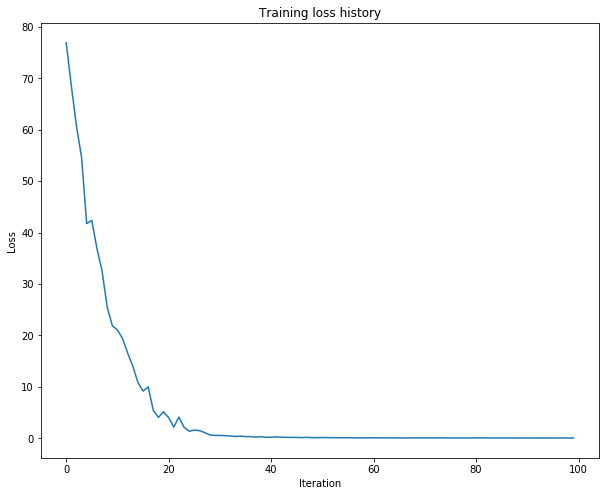

In [14]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
        )

small_rnn_solver = CaptioningSolver(small_rnn_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.95,
           verbose=True, print_every=10,
         )

small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# 测试时间取样
与分类模型不同，图像字幕模型在训练时和测试时的表现非常不同。在训练时，我们可以访问ground-truth标题，因此我们在每一步都向RNN输入ground-truth单词。在测试时，我们在每个时间步上从词汇表上的分布抽样，并在下一个时间步上将抽样作为输入提供给RNN。
在文件' cs231n/classifiers/rnn中。，实现用于测试时间抽样的“sample”方法。这样做之后，从您的过度拟合模型中对培训和验证数据运行以下示例。培训数据上的样本应该很好;验证数据上的示例可能没有意义。

http://farm5.staticflickr.com/4151/5003644046_1122a796c9_z.jpg


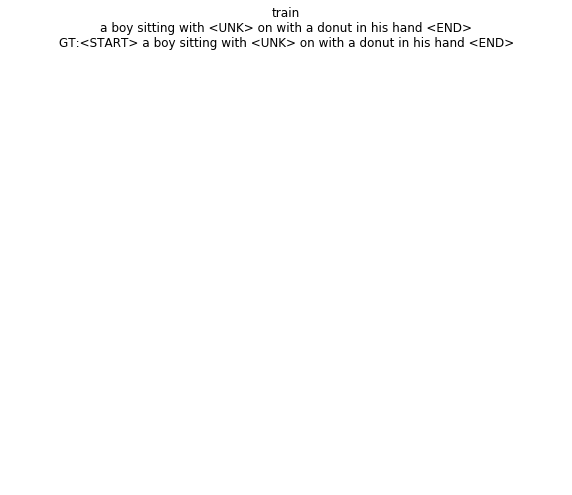

http://farm5.staticflickr.com/4134/4876982491_5359f44020_z.jpg


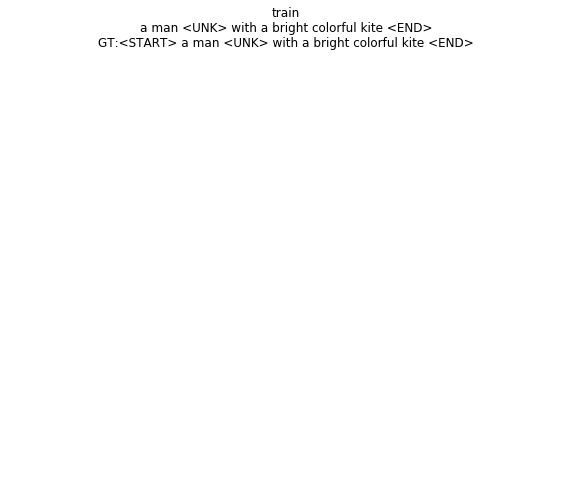

http://farm5.staticflickr.com/4086/5218606605_68fb694d6c_z.jpg


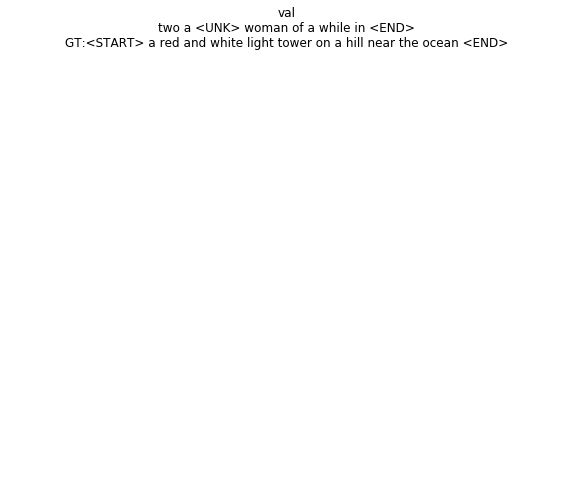

http://farm4.staticflickr.com/3019/2823442974_16c196c54c_z.jpg


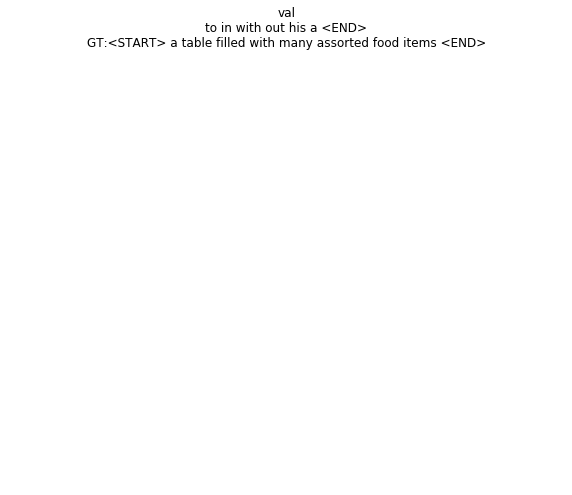

In [15]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
#         plt.imshow(image_from_url(url))
        print(url)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()